<a href="https://colab.research.google.com/github/uxzh/stock-prediction/blob/main/SNP500%20v1%20MSE0.22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries


In [1]:
# Install dependencies
!apt-get install -y build-essential wget

# Download and install TA-Lib from source
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install

# Install the ta-lib Python wrapper
!pip install ta-lib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
wget is already the newest version (1.21.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
--2024-06-07 14:46:39--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-06-07 14:46:39--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent,

In [2]:
# Install required libraries
!pip install yfinance
!pip install requests
!pip install beautifulsoup4

In [9]:
import yfinance as yf
import pandas as pd
import requests
import bs4 as bs
import talib as ta

#Fetch Historical Stock Price Data

In [4]:
def get_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip()
        tickers.append(ticker)
    return tickers

In [5]:
# Fetch historical stock price data
ticker = '^GSPC'
start_date = '2010-01-01'
end_date = '2023-06-02'
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


#Preprocess the Data

In [10]:

# Preprocess the Data
df = pd.DataFrame(data['Close'])
df.rename(columns={'Close': 'Price'}, inplace=True)

# Fetch the list of S&P 500 tickers
sp500_tickers = get_sp500_tickers()

# Fetch fundamental financial data for S&P 500 companies
sp500_financials = {}
for ticker in sp500_tickers:
    try:
        ticker_financials = yf.download(ticker, start=start_date, end=end_date)
        if 'financialData' in ticker_financials:
            sp500_financials[ticker] = ticker_financials['financialData']
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Calculate technical indicators using ta-lib
df['SMA_20'] = ta.SMA(df['Price'], timeperiod=20)
df['RSI'] = ta.RSI(df['Price'], timeperiod=14)
df['MACD'], df['MACD_Signal'], _ = ta.MACD(df['Price'], fastperiod=12, slowperiod=26, signalperiod=9)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$BF.B: possibly delisted; No price data found  (1d 2010-01-01 -> 2023-06-02)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [15]:
import requests

news_api_key = 'h04XekL2lOhPEKMWA16hYO5shkNydnJIENHdqeRl'
news_url = f'https://api.marketaux.com/v1/news/all?symbols={",".join(sp500_tickers)}&filter_entities=true&language=en&api_token={news_api_key}&limit=50'

news_data = requests.get(news_url).json()

sentiment_scores = []
for article in news_data['data']:
    if article['entities']:
        article_sentiment_scores = [entity['sentiment_score'] for entity in article['entities']]
        sentiment_scores.extend(article_sentiment_scores)

# Assign sentiment scores to DataFrame
if sentiment_scores:
    df['News_Sentiment'] = 0  # Set default sentiment score to 0
    df.iloc[:len(sentiment_scores), df.columns.get_loc('News_Sentiment')] = sentiment_scores
else:
    df['News_Sentiment'] = 0  # Set default sentiment score to 0 if no scores are available

# Print the results
print("Sentiment Scores:")
print(sentiment_scores)
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Tail:")
print(df.tail())
print("\nDataFrame Info:")
print(df.info())
print("\nNews Sentiment Column:")
print(df['News_Sentiment'])

Sentiment Scores:
[-0.3182, -0.24695, -0.4939, -0.052114]

DataFrame Head:
                  Price  SMA_20  RSI  MACD  MACD_Signal  News_Sentiment
Date                                                                   
2010-01-04  1132.989990     NaN  NaN   NaN          NaN       -0.318200
2010-01-05  1136.520020     NaN  NaN   NaN          NaN       -0.246950
2010-01-06  1137.140015     NaN  NaN   NaN          NaN       -0.493900
2010-01-07  1141.689941     NaN  NaN   NaN          NaN       -0.052114
2010-01-08  1144.979980     NaN  NaN   NaN          NaN        0.000000

DataFrame Tail:
                  Price       SMA_20        RSI       MACD  MACD_Signal  \
Date                                                                      
2023-05-25  4151.279785  4139.724500  52.980501  15.507297    17.871916   
2023-05-26  4205.450195  4141.523010  59.435503  18.961862    18.089905   
2023-05-30  4205.520020  4143.405505  59.443232  21.457911    18.763506   
2023-05-31  4179.830078  4146

#Handle Missing Values

In [26]:
# Handle missing values in the original data
df.fillna(method='ffill', inplace=True)  # Forward fill missing values
df.fillna(method='bfill', inplace=True)  # Backward fill any remaining missing values


#Normalize the Data

In [27]:
from sklearn.preprocessing import MinMaxScaler


# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
df[['Price', 'SMA_20', 'RSI', 'MACD', 'MACD_Signal']] = scaler.fit_transform(df[['Price', 'SMA_20', 'RSI', 'MACD', 'MACD_Signal']])


#Create Input Sequences

In [28]:
import numpy as np

# Create input sequences and target values
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(df)):
    if pd.notnull(df[['Price', 'SMA_20', 'RSI', 'MACD', 'MACD_Signal', 'News_Sentiment']][i-sequence_length:i]).all().all():
        X.append(df[['Price', 'SMA_20', 'RSI', 'MACD', 'MACD_Signal', 'News_Sentiment']][i-sequence_length:i])
        y.append(df['Price'][i])

X = np.array(X)
y = np.array(y)


#Split the Data

In [29]:
# Split the data into training, validation, and testing sets
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


#Reshape the Input Data

In [30]:
# Reshape the input data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


#Build the LSTM Model

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

#Compile the Model

In [32]:

model.compile(optimizer='adam', loss='mean_squared_error')


#Train the Model

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint])


Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.4261
Epoch 1: val_loss improved from inf to 0.32827, saving model to best_model.h5
63/63 [==============================] - 18s 151ms/step - loss: 0.4261 - val_loss: 0.3283
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - ETA: 0s - loss: 0.1562
Epoch 2: val_loss improved from 0.32827 to 0.20433, saving model to best_model.h5
63/63 [==============================] - 8s 120ms/step - loss: 0.1562 - val_loss: 0.2043
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.0883
Epoch 3: val_loss improved from 0.20433 to 0.16306, saving model to best_model.h5
63/63 [==============================] - 8s 135ms/step - loss: 0.0883 - val_loss: 0.1631
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.0654
Epoch 4: val_loss did not improve from 0.16306
63/63 [==============================] - 7s 112ms/step - loss: 0.0654 - val_loss: 0.1832
Epoch 5/100
63/63 [==============================] - ETA: 0s - loss: 0.0426
Epoch 5: val_loss improved from 0.16306 to 0.15376, saving model to best_model.h5
63/63 [==============================] - 9s 138ms/step - loss: 0.0426 - val_loss: 0.1538
Epoch 6/100
63/63 [==============================] - ETA: 0

#Evaluate the Model

In [34]:
from sklearn.metrics import mean_squared_error

# Evaluate the model on the testing data
predictions = model.predict(X_test)
predictions = np.squeeze(predictions)  # Remove single-dimensional entries

# Handle NaN values in predictions
predictions = np.nan_to_num(predictions)

mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')

21/21 [==============================] - 2s 30ms/step
Test MSE: 0.22666394929521358


#Visualize the Results

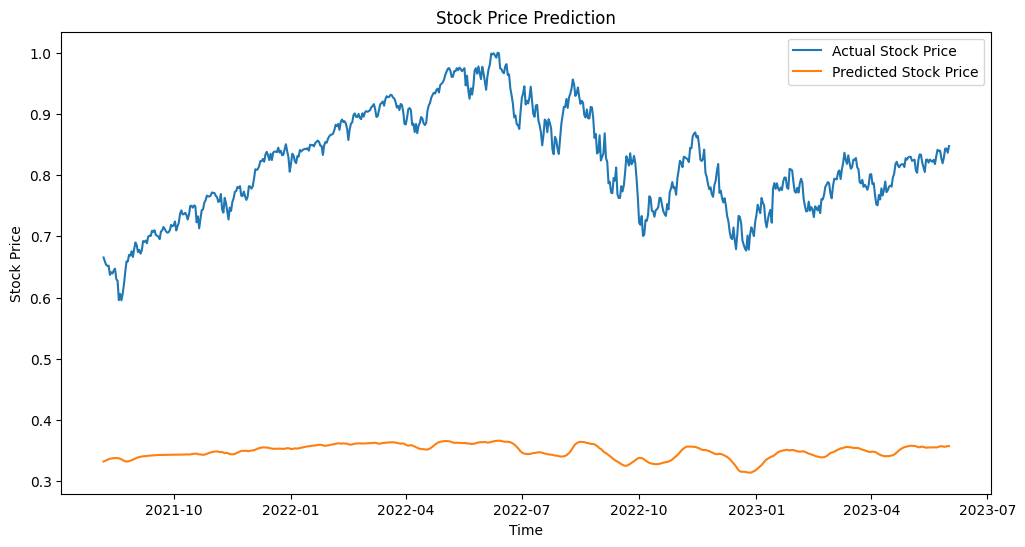

In [39]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

# Create a new scaler for the 'Price' column
price_scaler = MinMaxScaler()
price_scaler.fit(df[['Price']])

# Inverse transform the predictions and actual values using the price_scaler
predicted_stock_price = price_scaler.inverse_transform(predictions.reshape(-1, 1))
real_stock_price = price_scaler.inverse_transform(y_test.reshape(-1, 1))

# Create the test dates based on the length of the test data
test_dates = pd.date_range(end=data.index[-1], periods=len(y_test), freq='D')

# Create a DataFrame to store the actual and predicted prices
result_df = pd.DataFrame({'Actual': real_stock_price.flatten(), 'Predicted': predicted_stock_price.flatten()}, index=test_dates)

# Plot the actual and predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Actual'], label='Actual Stock Price')
plt.plot(result_df.index, result_df['Predicted'], label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
